# Download and extract Food 101 Dataset

* Add all the imports

In [ ]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import preprocess_input

import cv2
import os
import random
import collections
from collections import defaultdict

from shutil import copy
from shutil import copytree, rmtree

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

In [ ]:
# Check TF version and whether GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

2.7.0
/device:GPU:0


In [ ]:
# Clone tensorflow/examples repo which has images to evaluate trained model
!git clone https://github.com/tensorflow/examples.git

Cloning into 'examples'...
remote: Enumerating objects: 20141, done.
remote: Counting objects: 100% (1961/1961), done.
remote: Compressing objects: 100% (1057/1057), done.
remote: Total 20141 (delta 906), reused 1586 (delta 593), pack-reused 18180
Receiving objects: 100% (20141/20141), 33.15 MiB | 28.29 MiB/s, done.
Resolving deltas: 100% (11000/11000), done.


In [ ]:
# Helper function to download data and extract

def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    tf.keras.utils.get_file(
    'food-101.tar.gz',
    'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz',
    cache_subdir='/content',
    extract=True,
    archive_format='tar',
    cache_dir=None
    )
    print("Dataset downloaded and extracted!")

* The Food-101 dataset is 5GB in size. This might take some time to finish..

In [ ]:
# Download data and extract it to folder
get_data_extract()

4996292608/4996278331 [==============================] - 199s 0us/step
Dataset downloaded and extracted!


# Understand dataset structure and files 

* The dataset being used is [Food 101](https://www.vision.ee.ethz.ch/datasets_extra/food-101/)
* This dataset has 101000 images in total. It's a food dataset with 101 categories(multiclass)
* Each type of food has 750 training samples and 250 test samples
* Note found on the webpage of the dataset :  
* On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
* The entire dataset is 5GB in size

In [ ]:
# Check the extracted dataset folder
os.listdir('food-101/')

['meta', 'license_agreement.txt', 'README.txt', 'images']

**images** folder contains 101 folders with 1000 images  each  
Each folder contains images of a specific food class

In [ ]:
os.listdir('food-101/images')

['baby_back_ribs',
 'caesar_salad',
 'sushi',
 'beef_carpaccio',
 'tiramisu',
 'crab_cakes',
 'carrot_cake',
 'seaweed_salad',
 'escargots',
 'filet_mignon',
 'omelette',
 'spaghetti_carbonara',
 'shrimp_and_grits',
 'pizza',
 'hamburger',
 'spaghetti_bolognese',
 'nachos',
 'ravioli',
 'breakfast_burrito',
 'bruschetta',
 'french_onion_soup',
 'ceviche',
 'macaroni_and_cheese',
 'dumplings',
 'peking_duck',
 'hummus',
 'chocolate_mousse',
 'cheesecake',
 'red_velvet_cake',
 'bread_pudding',
 'baklava',
 'paella',
 'mussels',
 'bibimbap',
 'strawberry_shortcake',
 'pad_thai',
 'sashimi',
 'garlic_bread',
 'donuts',
 'samosa',
 'takoyaki',
 'waffles',
 'falafel',
 'deviled_eggs',
 'risotto',
 'foie_gras',
 'chicken_wings',
 'fried_calamari',
 'huevos_rancheros',
 'guacamole',
 'croque_madame',
 'beignets',
 'oysters',
 'ice_cream',
 'french_toast',
 'cup_cakes',
 'cheese_plate',
 'poutine',
 'lasagna',
 'chicken_quesadilla',
 'hot_dog',
 'club_sandwich',
 'caprese_salad',
 'beef_tartare

**meta** folder contains the text files - train.txt and test.txt  
**train.txt** contains the list of images that belong to training set  
**test.txt** contains the list of images that belong to test set  
**classes.txt** contains the list of all classes of food

In [ ]:
os.listdir('food-101/meta')

['train.txt',
 'train.json',
 'classes.txt',
 'test.json',
 'test.txt',
 'labels.txt']

# Visualize random image from each of the 101 classes

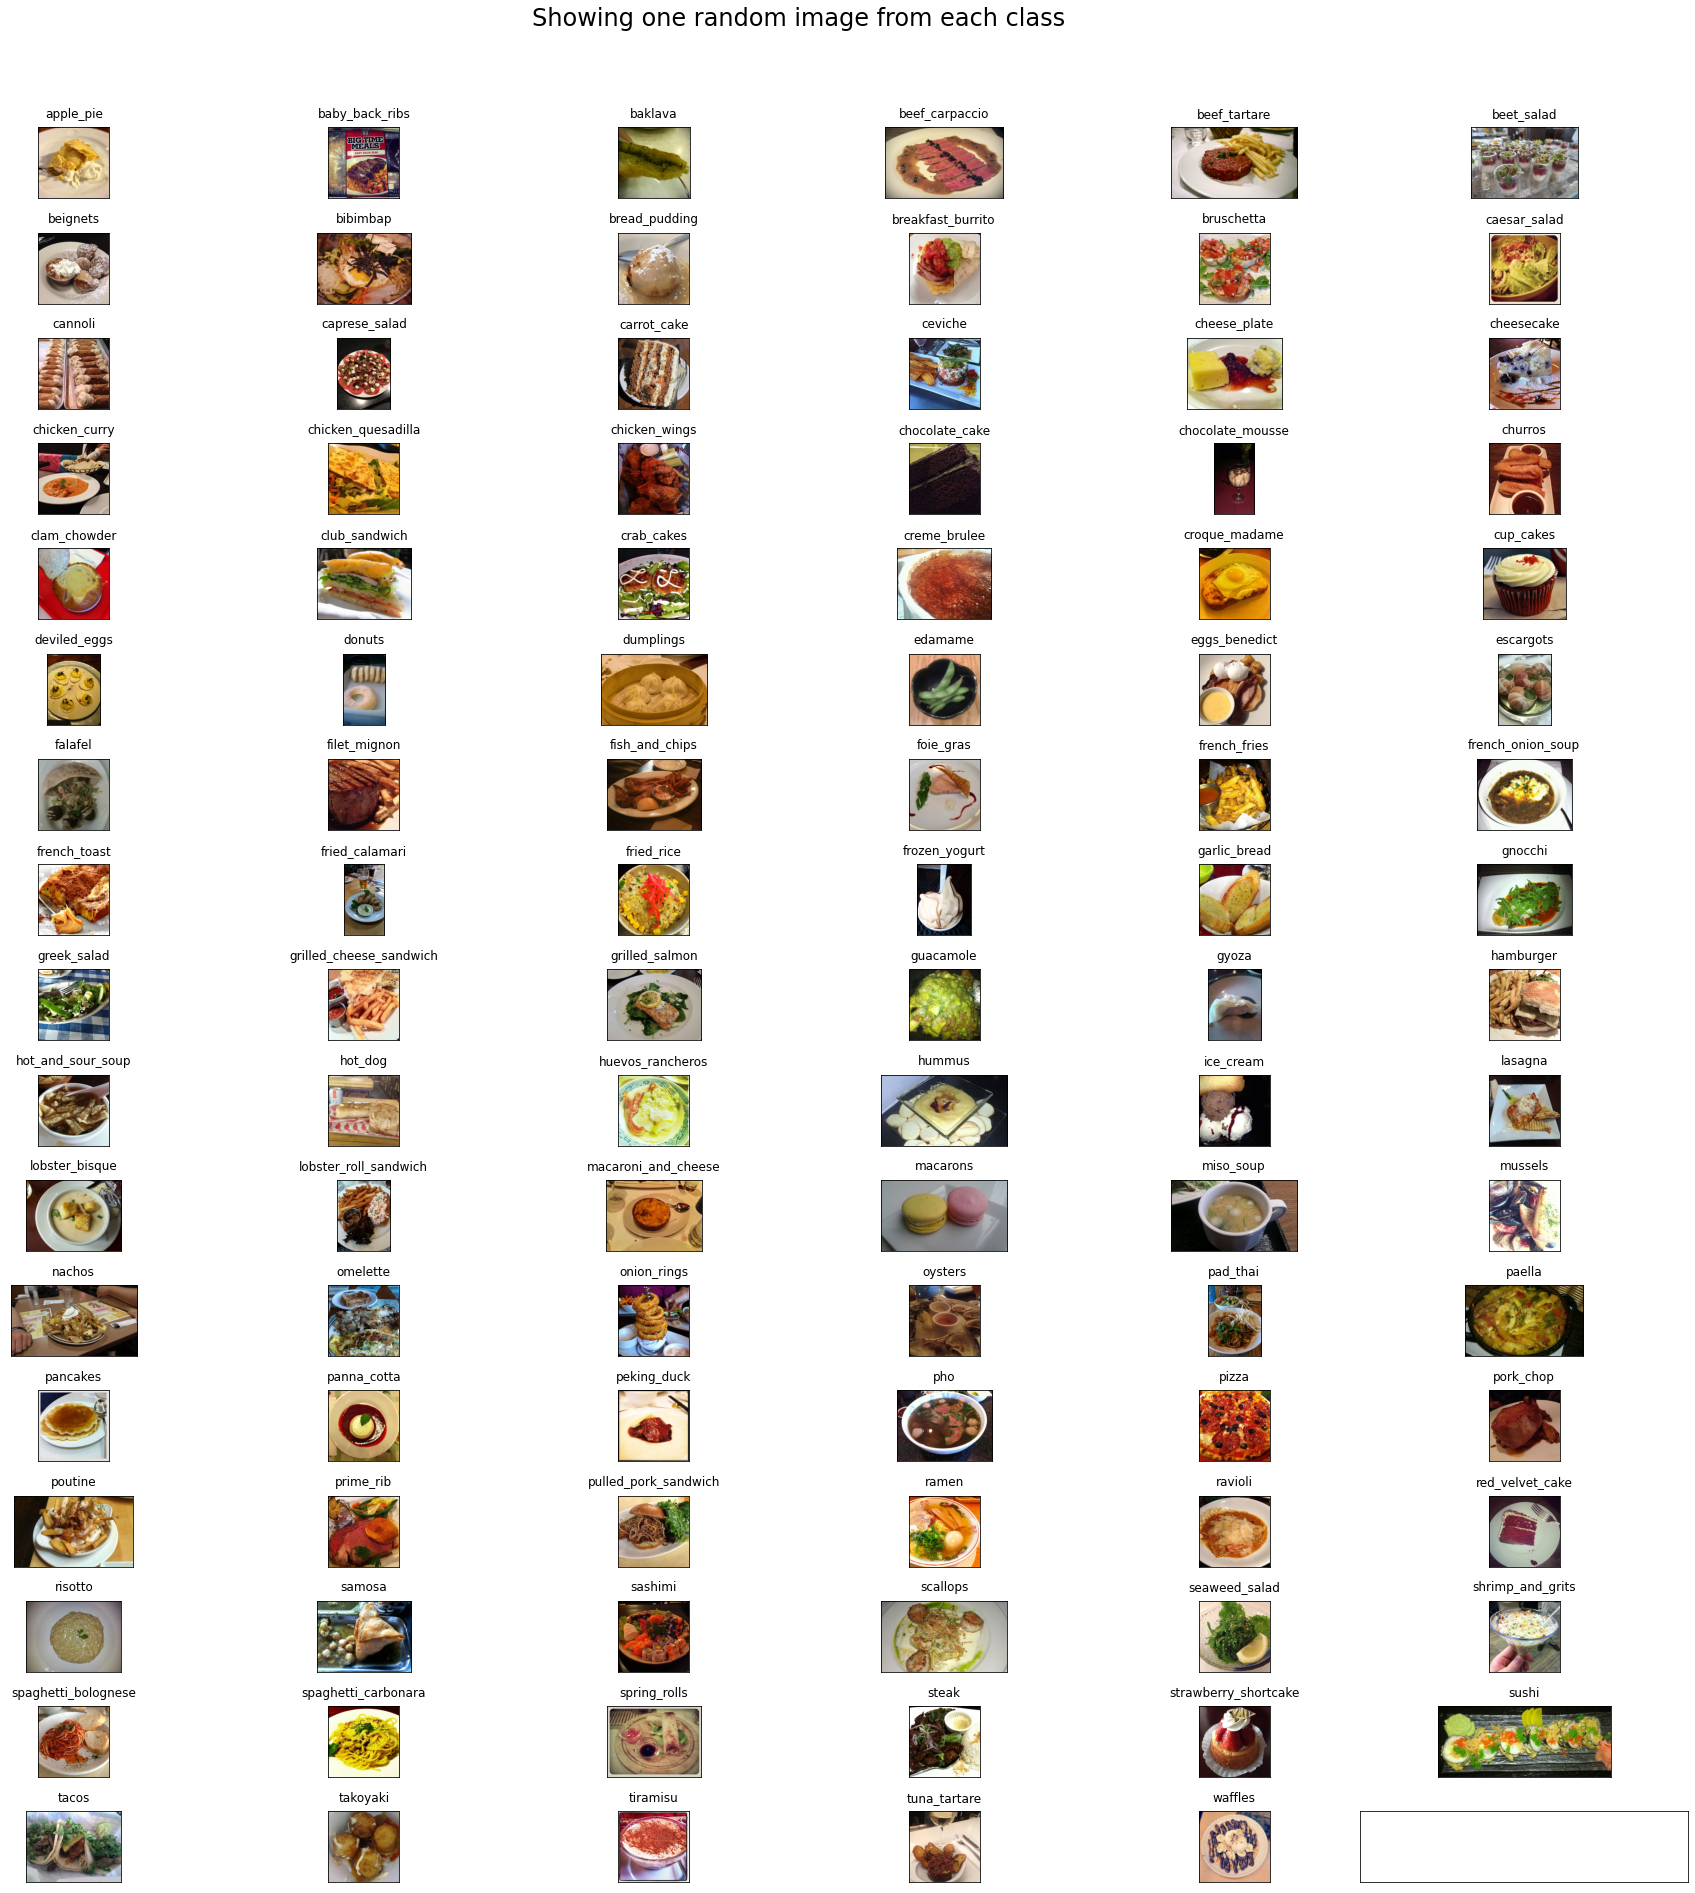

In [ ]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html


# Split the image data into train and test using train.txt and test.txt

In [ ]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [ ]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [ ]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [ ]:
# Check how many files are in the train folder

train_files = sum([len(files) for i, j, files in os.walk("food-101/train")])
print("Total number of samples in train folder")
print(train_files)

Total number of samples in train folder
75750


In [ ]:
# Check how many files are in the test folder
test_files = sum([len(files) for i, j, files in os.walk("food-101/test")])
print("Total number of samples in test folder")
print(test_files)

Total number of samples in test folder
25250


# Create a subset of data with few classes (3)

* We now have train and test data ready  
* But to experiment and try different architectures, working on the whole data with 101 classes takes a lot of time and computation  
* To proceed with further experiments, I am creating train_min and test_mini, limiting the dataset to 3 classes  
* Since the original problem is multiclass classification which makes key aspects of architectural decisions different from that of binary classification, choosing 3 classes is a good start instead of 2

In [ ]:
# List of all 101 types of foods(sorted alphabetically)
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [ ]:

food_list = ['chocolate_cake','chocolate_mousse', 'churros','pizza','omelette','hot_dog','ice_cream','pancakes','waffles','red_velvet_cake','panna_cotta','french_fries','donuts','cup_cakes','cheesecake']
src_train = 'food-101/train'
dest_train = 'food-101/train_mini'
src_test = 'food-101/test'
dest_test = 'food-101/test_mini'

In [ ]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into chocolate_cake
Copying images into chocolate_mousse
Copying images into churros
Copying images into pizza
Copying images into omelette
Copying images into hot_dog
Copying images into ice_cream
Copying images into pancakes
Copying images into waffles
Copying images into red_velvet_cake
Copying images into panna_cotta
Copying images into french_fries
Copying images into donuts
Copying images into cup_cakes
Copying images into cheesecake


In [ ]:
print("Total number of samples in train folder")
train_files = sum([len(files) for i, j, files in os.walk("food-101/train_mini")])
print(train_files)

Total number of samples in train folder
11250


In [ ]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into chocolate_cake
Copying images into chocolate_mousse
Copying images into churros
Copying images into pizza
Copying images into omelette
Copying images into hot_dog
Copying images into ice_cream
Copying images into pancakes
Copying images into waffles
Copying images into red_velvet_cake
Copying images into panna_cotta
Copying images into french_fries
Copying images into donuts
Copying images into cup_cakes
Copying images into cheesecake


In [ ]:
print("Total number of samples in test folder")
test_files = sum([len(files) for i, j, files in os.walk("food-101/test_mini")])
print(test_files)

Total number of samples in test folder
3750


# Fine tune Inception Pretrained model using Food 101 dataset

* Keras and other Deep Learning libraries provide pretrained models  
* These are deep neural networks with efficient architectures(like VGG,Inception,ResNet) that are already trained on datasets like ImageNet  
* Using these pretrained models, we can use the already learned weights and add few layers on top to finetune the model to our new data  
* This helps in faster convergance and saves time and computation when compared to models trained from scratch

* We currently have a subset of dataset with 3 classes - samosa, pizza and omelette  
* Use the below code to finetune Inceptionv3 pretrained model

In [ ]:
import time
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
time_callback = TimeHistory()

# model.fit(..., callbacks=[..., time_callback],...)
# times = time_callback.times

In [ ]:
def train_model(n_classes,num_epochs, nb_train_samples,nb_validation_samples):
  K.clear_session()

  img_width, img_height = 299, 299
  train_data_dir = 'food-101/train_mini'
  validation_data_dir = 'food-101/test_mini'
  batch_size = 16
  bestmodel_path = 'bestmodel_'+str(n_classes)+'class.hdf5'
  trainedmodel_path = 'trainedmodel_'+str(n_classes)+'class.hdf5'
  history_path = 'history_'+str(n_classes)+'.log'
  import os  
  import numpy as np  
  from keras.preprocessing import image 
  
  
  train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

  test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

  train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')

  validation_generator = test_datagen.flow_from_directory(
      validation_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')
  # example of loading the vgg16 model
  from tensorflow.keras.applications.vgg16 import VGG16

  

  inception = VGG16(weights='imagenet', include_top=False)
  x = inception.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(128,activation='relu')(x)
  x = Dropout(0.2)(x)

  predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)
  adam = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)
  model = Model(inputs=inception.input, outputs=predictions)
  model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
  checkpoint = ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only=True)
  csv_logger = CSVLogger(history_path)

  history = model.fit(train_generator,
                      steps_per_epoch = nb_train_samples // batch_size,
                      validation_data=validation_generator,
                      validation_steps=nb_validation_samples // batch_size,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=[csv_logger, checkpoint,time_callback])

  model.save(trainedmodel_path)
  class_map = train_generator.class_indices
  return history, class_map

In [ ]:
# Train the model with data from 3 classes
n_classes = 15
epochs = 20
nb_train_samples = train_files
nb_validation_samples = test_files

history, class_map_3 = train_model(n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_3)

Found 11250 images belonging to 15 classes.
Found 3750 images belonging to 15 classes.
58900480/58889256 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
703/703 [==============================] - ETA: 0s - loss: 2.4741 - accuracy: 0.2331
Epoch 00001: val_loss improved from inf to 1.70510, saving model to bestmodel_15class.hdf5
703/703 [==============================] - 658s 903ms/step - loss: 2.4741 - accuracy: 0.2331 - val_loss: 1.7051 - val_accuracy: 0.5091
Epoch 2/20
703/703 [==============================] - ETA: 0s - loss: 1.7919 - accuracy: 0.4795
Epoch 00002: val_loss improved from 1.70510 to 1.28273, saving model to bestmodel_15class.hdf5
703/703 [==============================] - 634s 901ms/step - loss: 1.7919 - accuracy: 0.4795 - val_loss: 1.2827 - val_accuracy: 0.6405
Epoch 3/20
703/703 [==============================] - ETA: 0s - loss: 1.4869 - accuracy: 0.5748
Epoch 00003: val_loss improved from 1.28273 to 1.19496, saving model to bestmodel_15class.hdf5
703/703 [==============================] - 634s 902ms/step - loss: 1.4869 - accuracy: 0.5748 - val_loss: 1.1950 - val_accuracy: 0.6782
Epoch 4/20
703/703 [======

In [ ]:
times = time_callback.times
times

[658.4123458862305,
 633.5219168663025,
 634.4587469100952,
 633.9181842803955,
 634.4388852119446,
 634.3592395782471,
 634.5452301502228,
 634.454728603363,
 634.4597826004028,
 633.7790858745575,
 633.9270765781403,
 634.3150022029877,
 634.0335080623627,
 630.4095773696899,
 626.5620889663696,
 626.5611882209778,
 628.7488236427307,
 633.9989986419678,
 634.0137958526611,
 633.6351268291473]

In [ ]:
def train_model(n_classes,num_epochs, nb_train_samples,nb_validation_samples):
  K.clear_session()

  img_width, img_height = 299, 299
  train_data_dir = 'food-101/train_mini'
  validation_data_dir = 'food-101/test_mini'
  batch_size = 16
  bestmodel_path = 'bestmodel_'+str(n_classes)+'class.hdf5'
  trainedmodel_path = 'trainedmodel_'+str(n_classes)+'class.hdf5'
  history_path = 'history_'+str(n_classes)+'.log'
  import os  
  import numpy as np  
  from keras.preprocessing import image 
  
  
  train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

  test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

  train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')

  validation_generator = test_datagen.flow_from_directory(
      validation_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')
  # example of loading the vgg16 model
  from tensorflow.keras.applications.vgg16 import VGG16

  

  model = load_model('/content/trainedmodel_15classvgg.hdf5',compile = False)
  model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
  checkpoint = ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only=True)
  csv_logger = CSVLogger(history_path)

  history = model.fit(train_generator,
                      steps_per_epoch = nb_train_samples // batch_size,
                      validation_data=validation_generator,
                      validation_steps=nb_validation_samples // batch_size,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=[csv_logger, checkpoint,time_callback])

  model.save(trainedmodel_path)
  class_map = train_generator.class_indices
  return history, class_map

In [ ]:
# Train the model with data from 3 classes
n_classes = 15
epochs = 20
nb_train_samples = train_files
nb_validation_samples = test_files

history, class_map_3 = train_model(n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_3)

Found 11250 images belonging to 15 classes.
Found 3750 images belonging to 15 classes.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
703/703 [==============================] - ETA: 0s - loss: 0.5555 - accuracy: 0.8600
Epoch 00001: val_loss improved from inf to 0.64031, saving model to bestmodel_15class.hdf5
703/703 [==============================] - 653s 896ms/step - loss: 0.5555 - accuracy: 0.8600 - val_loss: 0.6403 - val_accuracy: 0.8365
Epoch 2/20
703/703 [==============================] - ETA: 0s - loss: 0.5211 - accuracy: 0.8724
Epoch 00002: val_loss did not improve from 0.64031
703/703 [==============================] - 627s 891ms/step - loss: 0.5211 - accuracy: 0.8724 - val_loss: 0.6659 - val_accuracy: 0.8229
Epoch 3/20
703/703 [==============================] - ETA: 0s - loss: 0.5188 - accuracy: 0.8693
Epoch 00003: val_loss improved from 0.64031 to 0.61789, saving model to bestmodel_15class.hdf5
703/703 [==============================] - 627s 892ms/step - loss: 0.5188 - accuracy: 0.8693 - val_loss: 0.6179 - val_accuracy: 0.8443
Epoch 4/20
703/703 [==============================] - ETA: 0s - loss: 

In [ ]:
times1 = time_callback.times1
times1

# Visualize the accuracy and loss plots

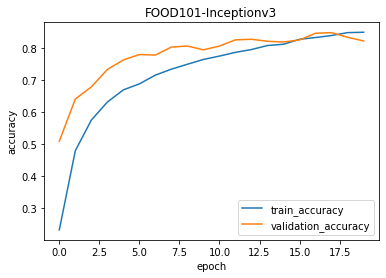

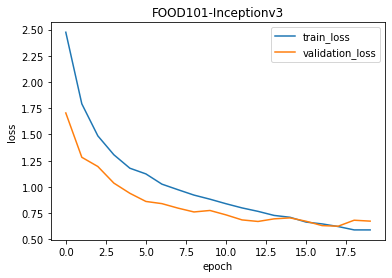

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy']) # change acc to accuracy if testing TF 2.0
    plt.plot(history.history['val_accuracy']) # change val_accuracy if testing TF 2.0
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

* The plots show that the accuracy of the model increased with epochs and the loss has decreased
* Validation accuracy has been on the higher side than training accuracy for many epochs
* This could be for several reasons:
  * We used a pretrained model trained on ImageNet which contains data from a variety of classes
  * Using dropout can lead to a higher validation accuracy
* The best model saved has a Top-1 validation accuracy of 93%
 


# Predicting classes for new images from internet using the best trained model

In [ ]:
%%time
# Loading the best saved model to make predictions

K.clear_session()
model_best = load_model('/content/bestmodel_15classvgg.hdf5',compile = False)

CPU times: user 251 ms, sys: 32.5 ms, total: 284 ms
Wall time: 284 ms


* **Setting compile=False and clearing the session leads to faster loading of the saved model**
* **Withouth the above addiitons, model loading was taking more than a minute!**

In [ ]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img = preprocess_input(img)                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    #print(pred)
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2672237.jpg
2596850.jpg
184954.jpg
587882.jpg


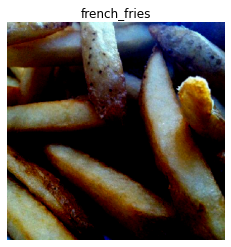

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


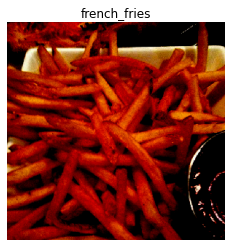

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


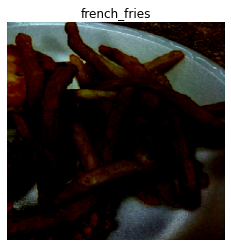

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


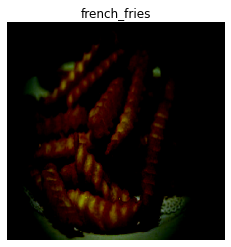

In [ ]:
# Make a list of images and test the trained model
import os
images = []
path = "/content/food-101/test_mini/french_fries"
dirs = os.listdir(path)
for dir in dirs[:4]:
  print(dir)
  images.append(path+"/"+dir)

# imagepath = '/content/examples/community/en/multi_class_classification/images/'
# images.append(imagepath+'samosa.jpg')
# images.append(imagepath+'pizza.jpg')
# images.append(imagepath+'omelette.jpg')
predict_class(model_best, images, True)

The model got them all right!